## 1. Import Data

In [143]:
# !pip install neuroCombat

In [144]:
kaggle = False
main_dir = '/kaggle/input/widsdatathon2025/' if kaggle else 'input/'

In [146]:
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from neuroHarmonize import harmonizationLearn, harmonizationApply
# import pycombat
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from joblib import parallel_backend
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.svm import NuSVC
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve
from scipy.stats import skew 
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


from imblearn.over_sampling import SMOTE
from lazypredict.Supervised import LazyClassifier

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
import torch.optim as optim
import torch
import time



import scipy.linalg

import geomstats.datasets.utils as data_utils
import geomstats.backend as gs
from geomstats.geometry.skew_symmetric_matrices import SkewSymmetricMatrices

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

cv_scores = {}

In [147]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [43]:
train_quantitative = pd.read_excel(f'{main_dir}/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx')
train_categorical = pd.read_excel(f'{main_dir}/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx')
train_mri = pd.read_csv(f'{main_dir}/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
train_labels = pd.read_excel(f'{main_dir}/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx')

pred_quantitative = pd.read_excel(f'{main_dir}/TEST/TEST_QUANTITATIVE_METADATA.xlsx')
pred_categorical = pd.read_excel(f'{main_dir}/TEST/TEST_CATEGORICAL.xlsx')
pred_mri = pd.read_csv(f'{main_dir}/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')

# train_mri = train_mri.merge(train_categorical[['participant_id', 'MRI_Track_Scan_Location']], on = 'participant_id')
# test_mri = test_mri.merge(test_categorical[['participant_id', 'MRI_Track_Scan_Location']], on = 'participant_id')

# drop MRI Scan location and Enrollment_year
train_categorical = train_categorical.drop(columns = ['Basic_Demos_Enroll_Year' ])
pred_categorical = pred_categorical.drop(columns = ['Basic_Demos_Enroll_Year' ])

train_data_frames = [train_mri, train_categorical, train_quantitative]
pred_data_frames = [pred_quantitative, pred_categorical, pred_mri]

In [44]:
train_df = reduce(lambda  left,right: pd.merge(left,right,on=['participant_id'],
                                            how='outer'), train_data_frames)
pred_df = reduce(lambda  left,right: pd.merge(left,right,on=['participant_id'],
                                            how='outer'), test_data_frames)
train_df.set_index('participant_id',inplace=True)
pred_df.set_index('participant_id',inplace=True)
train_labels.set_index('participant_id',inplace=True)



In [45]:
cv_scores = {}

In [46]:
quant_columns = train_quantitative.columns[1:].tolist()
cat_columns = train_categorical.columns[1:].tolist()
# cat_columns.remove("MRI_Track_Scan_Location")
mri_columns = train_mri.columns[1:].tolist()



In [47]:
train_df.merge(train_labels, on = 'participant_id').groupby(['MRI_Track_Scan_Location']).Sex_F.describe()

,count,mean,std,min,25%,50%,75%,max
MRI_Track_Scan_Location,,,,,,,,
1.00,179.00,0.40,0.49,0.00,0.00,0.00,1.00,1.00
2.00,532.00,0.34,0.47,0.00,0.00,0.00,1.00,1.00
3.00,463.00,0.33,0.47,0.00,0.00,0.00,1.00,1.00
4.00,36.00,0.17,0.38,0.00,0.00,0.00,0.00,1.00


## Transform features

In [48]:
# features to remove, MRI_Track_Scan_Location, Enrollment year

In [49]:
target_cols = ['ADHD_Outcome','Sex_F']
features = test_df.columns
features_nomri = quant_columns + cat_columns

In [50]:
missing_values_summ = train_df.isna().sum().reset_index()
missing_values_summ.columns = ['variable', 'count']
missing_values_summ.query('count>0')

,variable,count
19901,PreInt_Demos_Fam_Child_Ethnicity,43
19902,PreInt_Demos_Fam_Child_Race,54
19903,MRI_Track_Scan_Location,3
19904,Barratt_Barratt_P1_Edu,15
19905,Barratt_Barratt_P1_Occ,31
19906,Barratt_Barratt_P2_Edu,198
19907,Barratt_Barratt_P2_Occ,222
19908,EHQ_EHQ_Total,13
19909,ColorVision_CV_Score,23
19910,APQ_P_APQ_P_CP,12


In [51]:
all_quant = quant_columns + mri_columns
skewed_cols = [i for i in train_df.columns if (train_df[i]>=0).all() and scipy.stats.skew(train_df[i]) > 0]

def round_and_convert_to_category(df, columns):
    """
    Rounds the integer values in the specified categorical columns and converts them to 'category' dtype.
    """
    df[columns] = df[columns].apply(lambda x: np.ceil(x).astype(int))  # Round up to nearest integer
    df[columns] = df[columns].astype('category')  # Convert to 'category' dtype
    return df


imputer = ColumnTransformer([
    ('imputer_quant', SimpleImputer(strategy='median'), quant_columns),
    ('imputer_cat1', SimpleImputer(strategy='constant', fill_value=3), ['PreInt_Demos_Fam_Child_Ethnicity']),
    ('imputer_cat2', SimpleImputer(strategy='constant', fill_value=-1), list(set(cat_columns) - set(['PreInt_Demos_Fam_Child_Ethnicity']))),
], remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

skewer = ColumnTransformer([
    ('log', FunctionTransformer(np.log1p), skewed_cols)
], remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

scaler = ColumnTransformer([
    ('scaler', StandardScaler(), all_quant)
], remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')


# ColumnTransformer for categorical preprocessing (handling missing values + encoding)
converter = ColumnTransformer([
    ('round_and_convert', FunctionTransformer(lambda x: round_and_convert_to_category(x, cat_columns), validate=False), cat_columns),
], remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

encoder = ColumnTransformer([
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_columns)
], remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')



In [52]:
preprocessor = make_pipeline(imputer, skewer, scaler,
                            converter, encoder)
train_tf = preprocessor.fit_transform(train_df)
pred_tf = preprocessor.transform(pred_df)

In [14]:
adhd_females = (train_labels[target_cols[0]] == 1) & (train_labels[target_cols[1]] == 1)
sample_weights = np.where(adhd_females, 2, 1)

#### CV definitions

In [15]:
def weighted_f1_score(y_true, y_pred):
    # Ensure y_true and y_pred are NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # ADHD_Outcome column (index 1), Sex_F column (index 0)
    ADHD_Outcome = y_true[:, 0]
    Sex_F = y_true[:, 1]

    # Identify Female ADHD cases (where ADHD_Outcome=1 and Sex_F=1)
    female_adhd_mask = (ADHD_Outcome == 1) & (Sex_F == 1)

    # Compute F1-score for ADHD_Outcome (with 2x weight for Female ADHD cases)
    f1_adhd = f1_score(ADHD_Outcome, y_pred[:, 0], sample_weight=1 + female_adhd_mask)

    # Compute F1-score for Sex_F (with 2x weight for Female ADHD cases)
    f1_sex = f1_score(Sex_F, y_pred[:, 1], sample_weight=1 + female_adhd_mask)

    # Compute final score as the average of both F1-scores
    return (f1_adhd + f1_sex) / 2


    
    
def calculate_cv(X_score, y_score, model, name):
    if isinstance(X_score, np.ndarray):
        X_train_reset = pd.DataFrame(X_score)
        y_train_reset = pd.DataFrame(y_score)  # Assuming y_score is also a NumPy array
    else:
        X_train_reset = X_score.reset_index(drop=True)
        y_train_reset = y_score.reset_index(drop=True)
    mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_macro_scores = []
    f1_micro_scores = []
    f1_weighted_scores = []
    # Iterate through folds
    for train_idx, val_idx in mskf.split(X_score, y_score):
        X_train_fold, X_val_fold = X_train_reset.iloc[train_idx], X_train_reset.iloc[val_idx]
        y_train_fold, y_val_fold = y_train_reset.iloc[train_idx], y_train_reset.iloc[val_idx]
        
        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_val_fold)
        f1_macro = f1_score(y_val_fold, preds, average="macro")
        f1_micro = f1_score(y_val_fold, preds, average="micro")
        f1_weighted = weighted_f1_score(y_val_fold, preds)  # Custom function
        
        # Store scores
        f1_macro_scores.append(f1_macro)
        f1_micro_scores.append(f1_micro)
        f1_weighted_scores.append(f1_weighted)

    cv_scores[f'{name}'] = {'f1_macro': np.mean(f1_macro_scores),
                         'f1_micro': np.mean(f1_micro_scores),
                         'f1_weighted': np.mean(f1_weighted_scores)
                        }
    return cv_scores

### MRI

In [16]:
class LoadMRI():
    def __init__(self, df):
        self.df = df
        # self.labels = labels

    def load_and_correct_data(self, as_vectors=False):
        """
        This method combines both loading the MRI data and correcting for SPD in one step.
        """
        # Extract patient IDs and the rest of the features
        patient_ids = np.array(self.df['participant_id'])
        data = np.array(self.df.drop('participant_id', axis=1))

        if as_vectors:
            return data, patient_ids  # Return data and patient_ids if requested

        # Generate skew-symmetric matrices from the data
        mat = SkewSymmetricMatrices(200).matrix_representation(data)
        mat = gs.eye(200) - gs.transpose(gs.tril(mat), (0, 2, 1))
        mat = 1.0 / 2.0 * (mat + gs.transpose(mat, (0, 2, 1)))

        # Apply SPD correction to the matrices
        corrected_matrices = np.array([self.spd_correct(slice) for slice in mat])

        # Convert corrected matrices and labels to tensors
        connectivity_matrices = torch.tensor(corrected_matrices).float()
        

        # Call the new function to generate graph data objects
        # if self.labels is None:
        data_list = self.create_graph_data(connectivity_matrices)
        # else:
        #     target = gs.array(self.labels)
        #     data_list = self.create_graph_data(connectivity_matrices, torch.tensor(target).float())

        return corrected_matrices, data_list, patient_ids


    def spd_correct(self, matrix):
        eigenvalues = np.linalg.eigvals(matrix)
        min_eigenvalue = np.min(eigenvalues)
        if min_eigenvalue < 0:
            correction = -min_eigenvalue + 1e-6
            correction_matrix = correction * np.eye(matrix.shape[0])
            return matrix + correction_matrix
        else:
            return matrix

    def create_graph_data(self, connectivity_matrices):
        """
        Generates a list of graph data objects from the corrected connectivity matrices.
        """
        # Precompute identity matrix once
        identity_matrix = torch.eye(200)

        # Create graph data objects for each matrix
        data_list = []
        for i in range(len(connectivity_matrices)):
            matrix = connectivity_matrices[i]

            # Use sparse representation to avoid dense matrix and non-zero creation overhead
            edge_index = (matrix > 0).nonzero(as_tuple=False).t()
            edge_attr = matrix[edge_index[0], edge_index[1]]

            # Use precomputed identity matrix for node features (no need to create it in each loop)
            x = identity_matrix

            # Create graph data object
            # if labels is None:
            graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
            # else:
                # graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=labels[i].unsqueeze(0))
            data_list.append(graph_data)

        return data_list

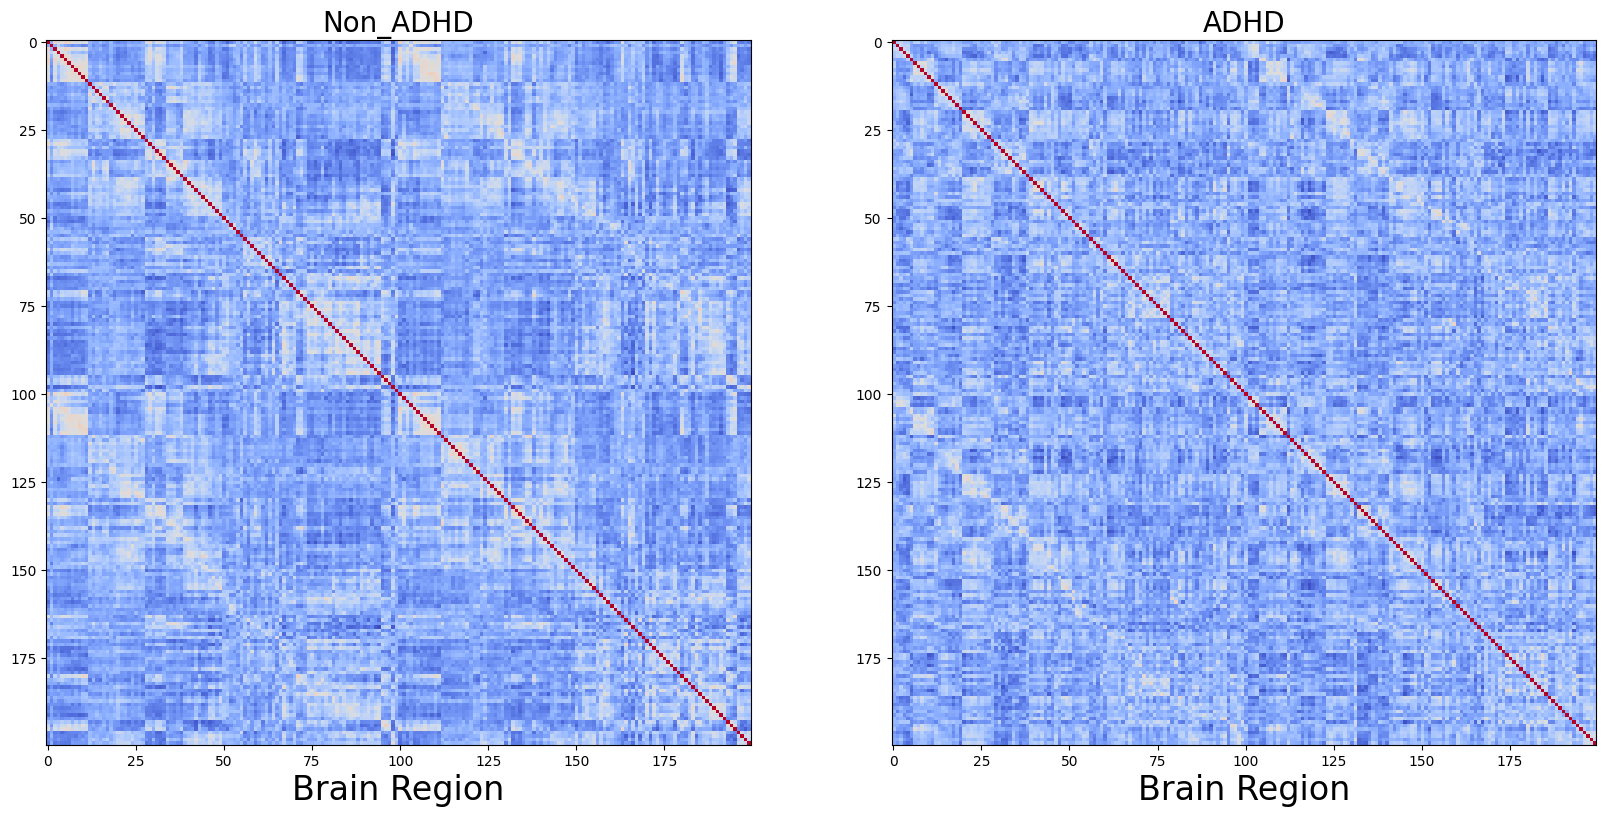

In [297]:
# Randomly select one ADHD patient and one non-ADHD patient
labels = gs.array(train_labels['ADHD_Outcome'])
label_str = ['Non_ADHD', 'ADHD']
adhd_idx = train_labels.reset_index().query('ADHD_Outcome == 1').sample(n=1).index.values[0]
non_adhd_idx = train_labels.reset_index().query('ADHD_Outcome == 0').sample(n=1).index.values[0]
fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(121)
imgplot1 = ax1.imshow(mri_corrected[non_adhd_idx], cmap = 'coolwarm')
ax1.set_title(label_str[int(labels[non_adhd_idx])], fontsize = 20)
ax1.set_xlabel('Brain Region', fontsize = 24)
ax1.set_xlabel('Brain Region', fontsize = 24)

ax2 = fig.add_subplot(122)
imgplot1 = ax2.imshow(mri_corrected[adhd_idx], cmap = 'coolwarm')
ax2.set_title(label_str[int(labels[adhd_idx])], fontsize = 20)
ax2.set_xlabel('Brain Region', fontsize = 24)
ax2.set_xlabel('Brain Region', fontsize = 24)

plt.show()

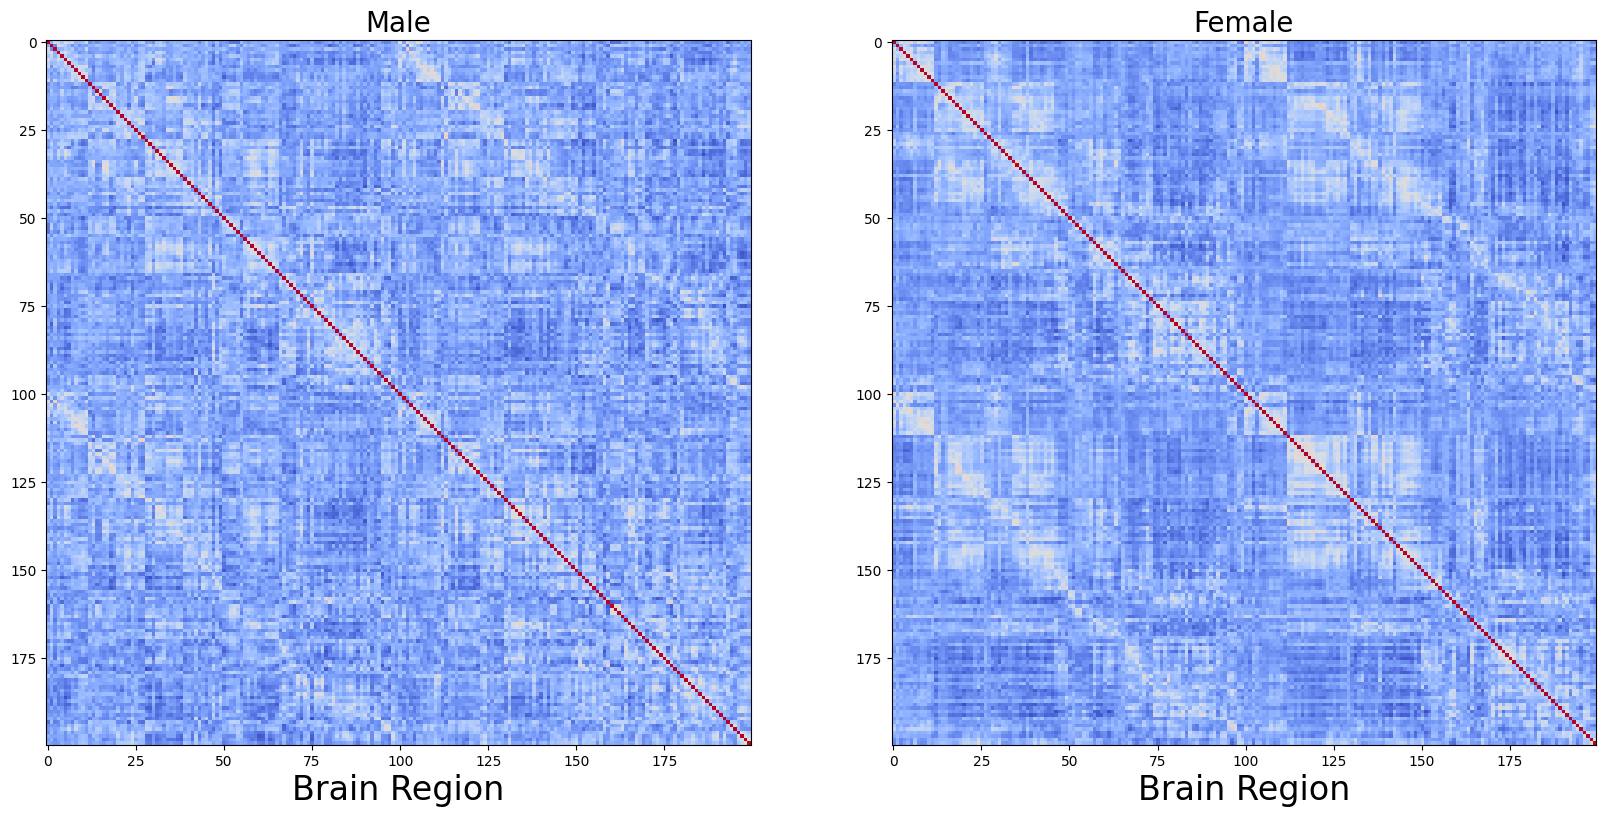

In [298]:
# Randomly select one ADHD patient and one non-ADHD patient
sex_labels = gs.array(train_labels['Sex_F'])
label_str = ['Male', 'Female']
female = train_labels.reset_index().query('Sex_F == 1').sample(n = 1).index.values[0]
male = train_labels.reset_index().query('Sex_F == 0').sample(n=1).index.values[0]
fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(121)
imgplot1 = ax1.imshow(mri_corrected[male], cmap = 'coolwarm')
ax1.set_title(label_str[int(sex_labels[male])], fontsize = 20)
ax1.set_xlabel('Brain Region', fontsize = 24)
ax1.set_xlabel('Brain Region', fontsize = 24)

ax2 = fig.add_subplot(122)
imgplot1 = ax2.imshow(mri_corrected[female], cmap = 'coolwarm')
ax2.set_title(label_str[int(sex_labels[female])], fontsize = 20)
ax2.set_xlabel('Brain Region', fontsize = 24)
ax2.set_xlabel('Brain Region', fontsize = 24)

plt.show()

### GCN

#### 1. Data preprocessing

In [17]:
# Custom dataset for graph data and labels
from torch_geometric.data import Data


class TrainDataset(Dataset):
    def __init__(self, graph_data, labels, other_features):
        self.graph_data = graph_data
        self.labels = labels
        self.labels = torch.tensor(self.labels, dtype=torch.float32)       
        self.other_features = torch.tensor(other_features.values, dtype=torch.float32)

    def __len__(self):
        return len(self.graph_data)

    def __getitem__(self, idx):
        # Fetch graph data for the given index
        graph = self.graph_data[idx]
        label = self.labels[idx]        
        other_feature = self.other_features[idx]

        return graph, label, other_feature

class TestDataset(Dataset):
    def __init__(self, graph_data, other_features):
        self.graph_data = graph_data
        self.other_features = other_features    
        self.other_features = torch.tensor(other_features.values, dtype=torch.float32)

    def __len__(self):
        return len(self.graph_data)

    def __getitem__(self, idx):
        # Fetch graph data for the given index
        graph = self.graph_data[idx]      
        other_feature = self.other_features[idx]

        return graph, other_feature


In [18]:
from imblearn.over_sampling import SMOTE
def apply_smote(graph_data, labels, other_features, target_col):
    labels_array = np.array(labels[target_col])  # Target column for SMOTE
    features_array = np.hstack([other_features.values, labels_array.reshape(-1, 1)])

    # Apply SMOTE
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    features_resampled, labels_resampled = smote.fit_resample(features_array, labels_array)

    # Graph data needs to be upsampled accordingly
    indices_resampled = smote.fit_resample(np.arange(len(graph_data)).reshape(-1, 1), labels_array)[0].flatten()
    graph_data_resampled = [graph_data[i] for i in indices_resampled]
    # Split back into components
    sex_resampled_df = pd.DataFrame(labels_resampled, columns=[target_col])
    other_features_resampled = pd.DataFrame(features_resampled[:, :-1], columns=other_features.columns)
    adhd_resampled_df = labels.iloc[indices_resampled]['ADHD_Outcome'].reset_index(drop=True)

    all_labels = np.array(pd.concat([adhd_resampled_df, sex_resampled_df], axis=1))

    return graph_data_resampled, all_labels, other_features_resampled

#### Harmonize MRI data

In [19]:
train_labels['composite_label'] = train_labels['ADHD_Outcome'].astype(str) + "_" + train_labels['Sex_F'].astype(str)
train_ids, test_ids = train_test_split(train_labels.index, test_size=0.3, random_state=42, stratify = train_labels['composite_label'])

In [20]:
# train test split
def prep_harmonizedata(mri_df, train_categorical, train_ids):
    mri_train_split = mri_df[mri_df['participant_id'].isin(train_ids)]
    mri_train_split = mri_train_split.drop(columns = 'participant_id').to_numpy()

    cat_split = train_categorical[train_categorical['participant_id'].isin(train_ids)]
    covars = cat_split[['MRI_Track_Scan_Location']].copy()
    covars['SITE'] = "SITE_" + covars['MRI_Track_Scan_Location'].astype(float).round(1).astype(str)
    covars = covars.drop(columns = ['MRI_Track_Scan_Location'])
    # Assume the training data had SITE values: 1, 2, 3, 4
    all_sites = ['SITE_1.0', 'SITE_2.0', 'SITE_3.0', 'SITE_4.0', 'SITE_nan']  # or actual site labels if strings
    # Convert to categorical with fixed categories
    covars['SITE'] = pd.Categorical(covars['SITE'], categories=all_sites)
    return mri_train_split, covars


In [21]:
def harmonize_data(mri_df, train_ids, test_ids):
    mri_train_split, covars_train = prep_harmonizedata(mri_df, train_categorical, train_ids)
    
    combat = CombatModel()
    combat.fit(mri_train_split, covars_train['SITE'])  # Trained on 5 sites

    test_mri_adj = combat.transform(test_data, covars_test['SITE'])
    train_ids = np.array(train_ids)
    test_ids = np.array(test_ids)
    train_mri_df = pd.DataFrame(train_mri_adj)
    train_mri_df['participant_id'] = train_ids

    test_mri_df = pd.DataFrame(test_mri_adj)
    test_mri_df['participant_id'] = test_ids
    return combat, train_mri_df, test_mri_df

In [22]:
# mri_train_split, covars =  prep_harmonizedata(train_mri, train_categorical, train_ids)

# combat = pycombat.PyCombat()
# combat.fit(mri_train_split, batch=covars)

In [23]:
# combat, train_mri_df, test_mri_df = harmonize_data(train_mri, train_ids, test_ids)

In [24]:
train_mri = train_mri.set_index('participant_id')
train_mri_df = train_mri.loc[train_ids]

In [ ]:
# loader = LoadMRI(train_mri_df.reset_index())

# # Apply SPD correction to the matrices
# mri_corrected, mri_input, patient_ids = loader.load_and_correct_data(as_vectors=False)

# torch.save(mri_input, 'mri_data/mri_input.pt')
# np.save('mri_data/mri_corrected.npy', mri_corrected)

# from geomstats.geometry.spd_matrices import SPDMatrices

# manifold = SPDMatrices(200, equip=False)
# print(gs.all(manifold.belongs(mri_corrected)))

RuntimeError: Parent directory mri_data does not exist.

In [ ]:
# # load test set 
# test_mri_df = train_mri.loc[test_ids]
# test_loader = LoadMRI(test_mri_df.reset_index())

# mri_corrected_test, mri_input_test, patient_ids_test = test_loader.load_and_correct_data(as_vectors=False)

# torch.save(mri_input_test, 'mri_data/mri_input_test.pt')
# np.save('mri_data/mri_corrected_test.npy', mri_corrected_test)

In [25]:
mri_corrected = np.load('mri_data/mri_corrected.npy')
mri_input = torch.load('mri_data/mri_input.pt')


mri_corrected_test = np.load('mri_data/mri_corrected_test.npy')
mri_input_test = torch.load('mri_data/mri_input_test.pt')

In [26]:
labels_train_df = train_labels.loc[train_ids][target_cols]
labels_test_df = train_labels.loc[test_ids][target_cols]
other_features_train = train_tf.loc[train_ids][list(set(train_tf.columns) - set(train_mri.columns))]
other_features_test = train_tf.loc[test_ids][list(set(train_tf.columns) - set(train_mri.columns))]

mri_resampled, labels_resampled, other_features_resampled = apply_smote(mri_input, labels_train_df, other_features_train, 'Sex_F')


train_dataset = TrainDataset(mri_resampled, 
labels_resampled, 
other_features_resampled)

test_dataset = TrainDataset(mri_input_test,
np.array(labels_test_df),
other_features_test)

# train_dataset = [combined_dataset[i] for i in train_indices]
# test_dataset = [combined_dataset[i] for i in test_indices]
features_train = [i[2] for i in train_dataset]
features_test = [i[2] for i in test_dataset]
labels_train = np.array([i[1] for i in train_dataset])
labels_test = np.array([i[1] for i in test_dataset])

torch.manual_seed(192024)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### 2. Model definition

In [124]:
class GCNClassifier(torch.nn.ModuleDict):
    def __init__(self, in_channels, hidden_dim, out_dim, num_classes1, num_classes2, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_dim) # 200, 
        self.conv2 = GCNConv(hidden_dim, out_dim) # 64
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # BatchNorm for first layer
        self.bn2 = nn.BatchNorm1d(out_dim)  # BatchNorm for second layer
        
        # Two classification heads for sex_f and adhd_outcome
        self.fc_sex = torch.nn.Linear(out_dim, num_classes1)  
        self.fc_adhd = torch.nn.Linear(out_dim, num_classes2)  
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.conv1(x, edge_index, edge_attr)
        x = self.bn1(x)  # Apply BatchNorm
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = self.bn2(x)  # Apply BatchNorm
        x = F.relu(x)  # Ensure non-linearity before pooling

        # Global Pooling (Graph-Level Embedding)
        x = global_mean_pool(x, batch)  # Shape: (num_graphs, 32)
        
        # Classification outputs
        sex_pred = self.fc_sex(x)  
        adhd_pred = self.fc_adhd(x)  
        
        return x, adhd_pred, sex_pred  # Returning embeddings + predictions

In [139]:
class PartiallySharedGCN(nn.Module):
    def __init__(self, in_channels, shared_dim, adhd_dim, sex_dim, num_classes_adhd, num_classes_sex, dropout_rate=0.5):
        super().__init__()

        # Shared first conv layer
        self.conv1 = GCNConv(in_channels, shared_dim)
        self.bn1 = nn.BatchNorm1d(shared_dim)
        self.dropout = nn.Dropout(dropout_rate)

        self.adhd_branch = nn.Sequential(
            nn.Linear(shared_dim, adhd_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        self.fc_adhd = nn.Linear(adhd_dim, num_classes_adhd)

        self.sex_branch = nn.Sequential(
            nn.Linear(shared_dim, sex_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        self.fc_sex = nn.Linear(sex_dim, num_classes_sex)


    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # Shared GCN + pooling
        x = self.conv1(x, edge_index, edge_attr)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = global_mean_pool(x, batch)  # Shared embedding: shape (batch_size, shared_dim)

        # Task-specific embeddings
        adhd_emb = self.adhd_branch(x)  # shape (batch_size, adhd_dim)
        sex_emb = self.sex_branch(x)    # shape (batch_size, sex_dim)

        # Predictions
        adhd_pred = self.fc_adhd(adhd_emb)
        sex_pred = self.fc_sex(sex_emb)

        return adhd_emb, sex_emb, adhd_pred, sex_pred

In [142]:
device = torch.device('cpu')
torch.backends.cudnn.enabled = False  # Disable cuDNN to get better error messages
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

num_features = 200

gcn_model = PartiallySharedGCN(in_channels=num_features, shared_dim=128, adhd_dim=64, sex_dim=64, num_classes_adhd=2, num_classes_sex=2, dropout_rate=0.7)
# gcn_model.apply(init_weights)
gcn_model = gcn_model.to(device) 
train_losses = []
val_losses = []
all_preds_adhd = []
all_labels_adhd = []
all_preds_sex = []
all_labels_sex = []


optimizer = optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=1e-4) 
class_labels = np.array([0, 1])

# Modify loss function
# Training loop for GCN
for epoch in range(100):  # Number of epochs
    start_time = time.time()  # Start timing
    gcn_model.train()
    epoch_loss = 0

    for graph_data_batch, label_batch, other_features_batch in train_loader:
        # Move data to device (if using CUDA)
        graph_data_batch = graph_data_batch.to(device)
        label_batch = label_batch.to(device)
        other_features_batch = other_features_batch.to(device)

        # Forward pass
        adhd_emb, sex_emb, adhd_output, sex_output = gcn_model(graph_data_batch)
        # print("First 10 sex logits:", sex_output[:10])
        # print(adhd_output.size(), label_batch[:, 0].size() )
        
        # Compute losses for each output
        loss_adhd = F.cross_entropy(adhd_output, label_batch[:, 0].long())  # ADHD Outcome
        loss_sex =  F.cross_entropy(sex_output, label_batch[:, 1].long()) 
        total_loss = loss_adhd + loss_sex
        
        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()

    gcn_model.eval()
    val_loss = 0

    with torch.no_grad():
        for graph_data_batch, label_batch, other_features_batch in test_loader:
            graph_data_batch = graph_data_batch.to(device)
            label_batch = label_batch.to(device)

            adhd_emb_test, sex_emb_test, adhd_pred_test, sex_pred_test = gcn_model(graph_data_batch)

            loss_adhd = F.cross_entropy(adhd_pred_test, label_batch[:, 0].long())
            loss_sex = F.cross_entropy(sex_pred_test, label_batch[:, 1].long())
            total_val_loss = loss_adhd + loss_sex

            val_loss += total_val_loss.item()

                                # Get the predicted classes
            adhd_preds = torch.argmax(adhd_pred_test, dim=1).cpu().numpy()  # ADHD predictions
            sex_preds = torch.argmax(sex_pred_test, dim=1).cpu().numpy()  # Sex predictions
            adhd_labels = label_batch[:, 0].cpu().numpy()  # ADHD ground truth
            sex_labels = label_batch[:, 1].cpu().numpy()  # Sex ground truth

            # Append to lists
            all_preds_adhd.extend(adhd_preds)
            all_labels_adhd.extend(adhd_labels)
            all_preds_sex.extend(sex_preds)
            all_labels_sex.extend(sex_labels)

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    epoch_time = time.time() - start_time

    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/100], Train Loss: {avg_epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {epoch_time:.2f}s')
        
torch.save(gcn_model.state_dict(), 'gcn_model.pth')
# Plot both training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GCN Training and Validation Loss')
plt.legend()
plt.show()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [126]:
if torch.cuda.is_available():
    device = torch.device('cuda')          # Use the GPU
else:
    device = torch.device('cpu')  

def get_nn_model(device, train=False):
    
    num_features = 200

    gcn_model = PartiallySharedGCN(in_channels=num_features, shared_dim=128, adhd_dim=64, sex_dim=64, num_classes_adhd=2, num_classes_sex=2, dropout_rate=0.7)
    # gcn_model.apply(init_weights)
    gcn_model = gcn_model.to(device) 
    train_losses = []
    val_losses = []
    all_preds_adhd = []
    all_labels_adhd = []
    all_preds_sex = []
    all_labels_sex = []

    if train:
        optimizer = optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=1e-4) 
        class_labels = np.array([0, 1])

        # Modify loss function
        # Training loop for GCN
        for epoch in range(100):  # Number of epochs
            start_time = time.time()  # Start timing
            gcn_model.train()
            epoch_loss = 0

            for graph_data_batch, label_batch, other_features_batch in train_loader:
                # Move data to device (if using CUDA)
                graph_data_batch = graph_data_batch.to(device)
                label_batch = label_batch.to(device)
                other_features_batch = other_features_batch.to(device)

                # Forward pass
                adhd_emb, sex_emb, adhd_output, sex_output = gcn_model(graph_data_batch)
                # print("First 10 sex logits:", sex_output[:10])
                # print(adhd_output.size(), label_batch[:, 0].size() )
                
                # Compute losses for each output
                print("sex_pred", sex_pred.shape)
                y_sex = label_batch[:, 1].long()
                print("y_sex", y_sex.shape, y_sex.unique())
                loss_adhd = F.cross_entropy(adhd_output, label_batch[:, 0].long())  # ADHD Outcome
                loss_sex =  F.cross_entropy(sex_output, label_batch[:, 1].long()) 
                total_loss = loss_adhd + loss_sex
                
                # Backward pass
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

                epoch_loss += total_loss.item()

            gcn_model.eval()
            val_loss = 0

            with torch.no_grad():
                for graph_data_batch, label_batch, other_features_batch in test_loader:
                    graph_data_batch = graph_data_batch.to(device)
                    label_batch = label_batch.to(device)

                    adhd_emb_test, sex_emb_test, adhd_pred_test, sex_pred_test = gcn_model(graph_data_batch)

                    loss_adhd = F.cross_entropy(adhd_pred_test, label_batch[:, 0].long())
                    loss_sex = F.cross_entropy(sex_pred_test, label_batch[:, 1].long())
                    total_val_loss = loss_adhd + loss_sex

                    val_loss += total_val_loss.item()

                                        # Get the predicted classes
                    adhd_preds = torch.argmax(adhd_pred_test, dim=1).cpu().numpy()  # ADHD predictions
                    sex_preds = torch.argmax(sex_pred_test, dim=1).cpu().numpy()  # Sex predictions
                    adhd_labels = label_batch[:, 0].cpu().numpy()  # ADHD ground truth
                    sex_labels = label_batch[:, 1].cpu().numpy()  # Sex ground truth

                    # Append to lists
                    all_preds_adhd.extend(adhd_preds)
                    all_labels_adhd.extend(adhd_labels)
                    all_preds_sex.extend(sex_preds)
                    all_labels_sex.extend(sex_labels)

            avg_val_loss = val_loss / len(test_loader)
            val_losses.append(avg_val_loss)

            avg_epoch_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_epoch_loss)
            epoch_time = time.time() - start_time

            if epoch % 10 == 0:
                print(f'Epoch [{epoch+1}/100], Train Loss: {avg_epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {epoch_time:.2f}s')
                
        torch.save(gcn_model.state_dict(), 'gcn_model.pth')
        # Plot both training and validation loss
        plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
        plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('GCN Training and Validation Loss')
        plt.legend()
        plt.show()
    else:
        gcn_model.load_state_dict(torch.load('gcn_model.pth'))
        gcn_model = gcn_model.to(device) 
    return gcn_model, train_losses, adhd_emb, sex_emb, all_preds_sex, all_preds_adhd, all_labels_sex, all_labels_adhd
    

In [127]:
gcn_model, _, adhd_emb, sex_emb, all_preds_sex, all_preds_adhd, all_labels_sex, all_labels_adhd = get_nn_model(device, True)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [118]:
precisions, recalls, thresholds = precision_recall_curve(all_sex_labels, all_sex_preds[:, 1])

# Compute F1 scores for all thresholds
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)  # Avoid division by zero

# Find the threshold that maximizes F1 score
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]


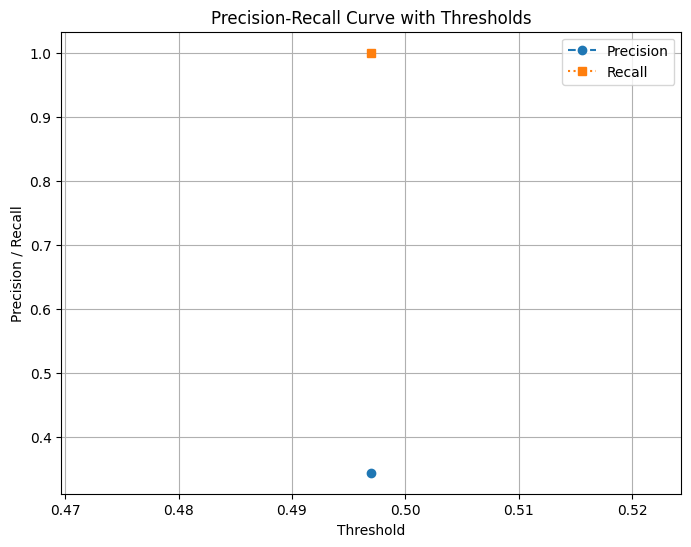

In [122]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label="Precision", marker="o", linestyle="dashed")
plt.plot(thresholds, recalls[:-1], label="Recall", marker="s", linestyle="dotted")

plt.xlabel("Threshold")
plt.ylabel("Precision / Recall")
plt.title("Precision-Recall Curve with Thresholds")
plt.legend()
plt.grid()
plt.show()

In [32]:
# Use the GCN output as features for XGBoost
start_time = time.time()
gcn_model.eval()
embeddings_list = []
with torch.no_grad():
    adhd_features_list = []
    sex_features_list = []
    
    for graph_data_batch, label_batch, other_features_batch in train_loader:
        # Move data to device (if using CUDA)
        graph_data_batch = graph_data_batch.to(device)

        adhd_emb, sex_emb, adhd_output, sex_output = gcn_model(graph_data_batch)
        combined_emb = torch.cat([adhd_emb, sex_emb], dim=1)
        embeddings_list.append(combined_emb.cpu().numpy())        

embeddings_train = np.vstack(embeddings_list)

# Concatenate with other features
combined_features_train = np.concatenate((embeddings_train, features_train), axis=1)

# Train XGBoost on combined features
# XGBoost model
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                               n_estimators=100, 
                               learning_rate=0.1, 
                               max_depth=6,
                               eval_metric='logloss'
)
# xgb_model = RidgeClassifier(alpha = 100)

# Wrap the XGBoost model with MultiOutputClassifier
multi_output_model = MultiOutputClassifier(xgb_model)
multi_output_model.fit(combined_features_train, labels_train)

xgb_time = time.time() - start_time
print(f'XGB training finished - time {xgb_time}')


XGB training finished - time 1.0416343212127686


In [33]:
# Evaluate on test data
start_time = time.time()
embeddings_list = []
with torch.no_grad():
    for graph_batch, label_batch, other_feature_batch in test_loader:
        graph_batch = graph_batch.to(device)

        adhd_emb, sex_emb, adhd_output, sex_output = gcn_model(graph_batch)
        combined_emb_test = torch.cat([adhd_emb, sex_emb], dim=1)
        embeddings_list.append(combined_emb_test.cpu().numpy())

embeddings_train = np.vstack(embeddings_list)
# Combine test set features
combined_features_test = np.concatenate((embeddings_train, features_test), axis=1)

# Predict
predictions = multi_output_model.predict(combined_features_test)

predict_time = time.time() - start_time
print(f'Predictions finished - time:{predict_time}')

# Compute F1-scores
f1_score_adhd = f1_score(labels_test[:, 0], predictions[:, 0], average='binary')
f1_score_sex = f1_score(labels_test[:, 1], predictions[:, 1], average='binary')
overall_f1_micro = f1_score(labels_test, predictions, average='micro')

print(f"F1 ADHD: {f1_score_adhd:.4f}, F1 Sex: {f1_score_sex:.4f}, Overall Micro: {overall_f1_micro:.4f}")

Predictions finished - time:0.2166576385498047
F1 ADHD: 0.8792, F1 Sex: 0.4319, Overall Micro: 0.7510


In [251]:
# adhd 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


results = []

X_adhd = pd.DataFrame(combined_features)
y_adhd = pd.DataFrame(y_adhd)

for train_index, test_index in skf.split(X_adhd, y_adhd):
    X_train, X_test = X_adhd.iloc[train_index], X_adhd.iloc[test_index]
    y_train, y_test = y_adhd.iloc[train_index], y_adhd.iloc[test_index]

    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    results.append(models)

metrics_df = pd.concat(results)
metrics_summary = metrics_df.groupby(metrics_df.index).agg(['mean', 'std'])
metrics_summary

100%|██████████| 32/32 [00:10<00:00,  3.01it/s]


Accuracy      Balanced Accuracy      ROC AUC  \
                                  mean  std              mean  std    mean   
Model                                                                        
AdaBoostClassifier                0.65 0.00              0.51 0.01    0.51   
BaggingClassifier                 0.59 0.01              0.53 0.01    0.53   
BernoulliNB                       0.58 0.02              0.54 0.02    0.54   
CalibratedClassifierCV            0.66 0.00              0.50 0.01    0.50   
DecisionTreeClassifier            0.58 0.01              0.53 0.02    0.53   
DummyClassifier                   0.66 0.00              0.50 0.00    0.50   
ExtraTreeClassifier               0.56 0.02              0.51 0.03    0.51   
ExtraTreesClassifier              0.68 0.02              0.55 0.01    0.55   
GaussianNB                        0.64 0.03              0.52 0.03    0.52   
KNeighborsClassifier              0.62 0.01              0.55 0.01    0.55   
LGBMClassifier                    0.65 0.02              0.54 0.02    0.54   
LabelPropagation                  0.34 0.00              0.50 0.00    0.50   
LabelSpreading                    0.34 0.00              0.50 0.00    0.50   
LinearDiscriminantAnalysis        0.63 0.04              0.53 0.04    0.53   
LinearSVC                         0.63 0.04              0.53 0.04    0.53   
LogisticRegression                0.63 0.04              0.53 0.03    0.53   
NearestCentroid                   0.57 0.03              0.54 0.04    0.54   
NuSVC                             0.65 0.02              0.56 0.02    0.56   
PassiveAggressiveClassifier       0.57 0.03              0.53 0.02    0.53   
Perceptron                        0.58 0.04              0.53 0.04    0.53   
QuadraticDiscriminantAnalysis     0.46 0.11              0.52 0.02    0.52   
RandomForestClassifier            0.65 0.01              0.51 0.01    0.51   
RidgeClassifier                   0.63 0.04              0.53 0.04    0.53   
RidgeClassifierCV                 0.63 0.04              0.52 0.03    0.52   
SGDClassifier                     0.58 0.03              0.52 0.02    0.52   
SVC                               0.66 0.01              0.51 0.01    0.51   

                                   F1 Score      Time Taken        
                               std     mean  std       mean   std  
Model                                                              
AdaBoostClassifier            0.01     0.56 0.02       0.81  0.01  
BaggingClassifier             0.01     0.58 0.01       0.96  0.05  
BernoulliNB                   0.02     0.58 0.02       0.04  0.00  
CalibratedClassifierCV        0.01     0.53 0.01       2.30  1.63  
DecisionTreeClassifier        0.02     0.58 0.02       0.19  0.03  
DummyClassifier               0.00     0.53 0.00       0.03  0.00  
ExtraTreeClassifier           0.03     0.56 0.02       0.04  0.00  
ExtraTreesClassifier          0.01     0.61 0.01       0.42  0.00  
GaussianNB                    0.03     0.58 0.03       0.04  0.00  
KNeighborsClassifier          0.01     0.60 0.01       0.04  0.00  
LGBMClassifier                0.02     0.61 0.02      13.77 28.83  
LabelPropagation              0.00     0.17 0.00       0.15  0.00  
LabelSpreading                0.00     0.17 0.00       0.26  0.04  
LinearDiscriminantAnalysis    0.04     0.60 0.04       0.77  1.30  
LinearSVC                     0.04     0.59 0.04       0.45  0.41  
LogisticRegression            0.03     0.59 0.03       2.62  1.23  
NearestCentroid               0.04     0.58 0.03       0.07  0.03  
NuSVC                         0.02     0.63 0.02       0.27  0.01  
PassiveAggressiveClassifier   0.02     0.57 0.03       0.06  0.00  
Perceptron                    0.04     0.58 0.04       0.15  0.01  
QuadraticDiscriminantAnalysis 0.02     0.41 0.18       0.24  0.06  
RandomForestClassifier        0.01     0.57 0.01       1.00  0.03  
RidgeClassifier               0.04     0.59 0.04       0.07  0.01  

In [ ]:
# adhd 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


results = []

X_sex = pd.DataFrame(combined_features)
y_sex = pd.DataFrame(y_sex)

for train_index, test_index in skf.split(X_sex, y_sex):
    X_train, X_test = X_adhd.iloc[train_index], X_adhd.iloc[test_index]
    y_train, y_test = y_adhd.iloc[train_index], y_adhd.iloc[test_index]

    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    results.append(models)

metrics_df = pd.concat(results)
metrics_summary = metrics_df.groupby(metrics_df.index).agg(['mean', 'std'])
metrics_summary

In [34]:
combined_features = np.vstack([combined_features_train, combined_features_test])

In [35]:
# ADHD Model Voting Ensemble
from sklearn.ensemble import VotingClassifier
adhd_voting = VotingClassifier(
    estimators=[
        # ('NuSVC', NuSVC()),  # Enable probability estimation
        ('LGBMClassifier', LGBMClassifier()),
        ('KNeighborsClassifier', KNeighborsClassifier(n_neighbors=5, weights='distance'))
    ],
    voting='soft'  # Use 'soft' for probability averaging, 'hard' for majority vote
)

# Sex Model Voting Ensemble
sex_voting = VotingClassifier(
    estimators=[
        ('KNeighborsClassifier', KNeighborsClassifier(n_neighbors=5, weights='distance')),
        ('GaussianNB', GaussianNB()),
        ('SGDClassifier', SGDClassifier(loss="log_loss"))  # Ensure probability estimation
    ],
    voting='soft'  # 'soft' for probability-based decision making
)

In [36]:
y_adhd = np.concatenate((labels_resampled[:, 0], labels_test_df['ADHD_Outcome'].to_numpy()), axis=0)
y_sex = np.concatenate((labels_resampled[:, 1], labels_test_df['Sex_F'].to_numpy()), axis=0)

In [37]:
adhd_voting.fit(combined_features, y_adhd)

VotingClassifier(estimators=[('LGBMClassifier', LGBMClassifier()),
                             ('KNeighborsClassifier',
                              KNeighborsClassifier(weights='distance'))],
                 voting='soft')

In [69]:
from sklearn.model_selection import GridSearchCV


# Example for ADHD Voting Ensemble
params = {
    'LGBMClassifier__n_estimators': [50, 100, 200],
    'LGBMClassifier__learning_rate': [0.01, 0.1, 0.2],
    'KNeighborsClassifier__n_neighbors': [3, 5, 7],
    'KNeighborsClassifier__weights': ['uniform', 'distance']
}

grid = GridSearchCV(adhd_voting, param_grid=params, cv=5, scoring='f1')
grid.fit(combined_features, y_adhd)
adhd_best_model = grid.best_estimator_

KeyboardInterrupt: 

In [65]:
adhd_best_model = grid.best_estimator_

In [38]:
sex_voting.fit(combined_features, y_sex)

VotingClassifier(estimators=[('KNeighborsClassifier',
                              KNeighborsClassifier(weights='distance')),
                             ('GaussianNB', GaussianNB()),
                             ('SGDClassifier', SGDClassifier(loss='log_loss'))],
                 voting='soft')

In [70]:
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

sgd_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('sgd', SGDClassifier(loss='log_loss', random_state=42))
])

gnb_pipe = Pipeline([
    ('gnb', GaussianNB())  # no scaler needed
])

sex_voting = VotingClassifier(
    estimators=[
        ('knn', knn_pipe),
        ('gnb', gnb_pipe),
        ('sgd', sgd_pipe)
    ],
    voting='soft'
)



param_grid = {
    'knn__knn__n_neighbors': [3, 5, 7],
    'knn__knn__weights': ['uniform', 'distance'],
    'sgd__sgd__alpha': [0.0001, 0.001, 0.01],
    'sgd__sgd__penalty': ['l2', 'l1', 'elasticnet']
}

grid = GridSearchCV(
    estimator=sex_voting,
    param_grid=param_grid,
    cv=5,
    scoring='f1',  # Or another appropriate metric
    n_jobs=-1
)
grid.fit(combined_features, y_sex)

GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('knn',
                                                     Pipeline(steps=[('scaler',
                                                                      StandardScaler()),
                                                                     ('knn',
                                                                      KNeighborsClassifier())])),
                                                    ('gnb',
                                                     Pipeline(steps=[('gnb',
                                                                      GaussianNB())])),
                                                    ('sgd',
                                                     Pipeline(steps=[('scaler',
                                                                      StandardScaler()),
                                                                     ('sgd',
                                                                      SGDClassifier(loss='log_loss',
                                                                                    random_state=42))]))],
                                        voting='soft'),
             n_jobs=-1,
             param_grid={'knn__knn__n_neighbors': [3, 5, 7],
                         'knn__knn__weights': ['uniform', 'distance'],
                         'sgd__sgd__alpha': [0.0001, 0.001, 0.01],
                         'sgd__sgd__penalty': ['l2', 'l1', 'elasticnet']},
             scoring='f1')

In [77]:
sex_best_model = grid.best_estimator_

In [83]:
feature_importances = {}

for name, model in adhd_voting.named_estimators_.items():
    if hasattr(model, "feature_importances_"):  # For tree-based models
        feature_importances[name] = model.feature_importances_
    elif hasattr(model, "coef_"):  # For linear models
        feature_importances[name] = np.abs(model.coef_).mean(axis=0)  # Mean for multi-class

# Combine feature importance (e.g., average importance)
# Generate feature names
embedding_feature_names = [f"Embedding_{i}" for i in range(64)]
df_feature_names = list(train_tf[list(set(train_tf.columns) - set(train_mri.columns))].columns) # Assuming df contains the 84 features

# Combine all feature names
feature_names = embedding_feature_names + df_feature_names

importance_df = pd.DataFrame(feature_importances, index=feature_names)
importance_df["Average"] = importance_df.mean(axis=1)  # Average importance

importance_df = importance_df.sort_values(by="Average", ascending = False)

# Plot top 20 features (adjust as needed)
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_df["Average"][:20], y=importance_df.index[:20], palette="viridis")

# Labels and title
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 20 Feature Importances for ADHD")
plt.show()


ValueError: Length of values (206) does not match length of index (142)

In [82]:
feature_importances = {}

for name, model in sex_voting.named_estimators_.items():
    if hasattr(model, "feature_importances_"):  # For tree-based models
        feature_importances[name] = model.feature_importances_
    elif hasattr(model, "coef_"):  # For linear models
        feature_importances[name] = np.abs(model.coef_).mean(axis=0)  # Mean for multi-class

# Combine feature importance (e.g., average importance)
# Generate feature names
embedding_feature_names = [f"Embedding_{i}" for i in range(64)]
df_feature_names = list(train_tf[list(set(train_tf.columns) - set(train_mri.columns))].columns) # Assuming df contains the 84 features

# Combine all feature names
feature_names = embedding_feature_names + df_feature_names

importance_df = pd.DataFrame(feature_importances, index=feature_names)
importance_df["Average"] = importance_df.mean(axis=1)  # Average importance

importance_df = importance_df.sort_values(by="Average", ascending = False)

# Plot top 20 features (adjust as needed)
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_df["Average"][:20], y=importance_df.index[:20], palette="viridis")

# Labels and title
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 20 Feature Importances for Sex_F")
plt.show()

AttributeError: 'VotingClassifier' object has no attribute 'named_estimators_'

In [274]:
# Set up Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate ADHD model using Stratified CV
adhd_scores = cross_val_score(adhd_voting, combined_features, y_adhd, cv=cv)
print(f"ADHD Model - Mean F1 Score: {np.mean(adhd_scores):.4f} ± {np.std(adhd_scores):.4f}")

ADHD Model - Mean F1 Score: 0.7453 ± 0.0122


In [275]:
# Set up Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate ADHD model using Stratified CV
sex_scores = cross_val_score(sex_voting, combined_features, y_sex, cv=cv)
print(f"Sex Model - Mean F1 Score: {np.mean(sex_scores):.4f} ± {np.std(sex_scores):.4f}")

Sex Model - Mean F1 Score: 0.5912 ± 0.0270


In [218]:
from tqdm import tqdm

thresholds = np.linspace(0, 1, 100)
y_adhd = combined_labels[:, 0]
y_sex = combined_labels[:, 1]
adhd_oof = np.zeros(len(combined_labels))
sex_oof = np.zeros(len(combined_labels))

scores_sex = []
scores_adhd = []

X = combined_features
y = combined_labels

# Repeated Stratified K-Fold
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)


for fold, (train_idx, val_idx) in enumerate(mskf.split(X, y), 1):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    train_labels_fold, val_labels_fold = y[train_idx], y[val_idx]

    adhd_females_train = np.logical_and(train_labels_fold[:, 0] == 1, train_labels_fold[:, 1] == 1)
    adhd_females_val = np.logical_and(val_labels_fold[:, 0] == 1, val_labels_fold[:, 1] == 1)
    weights_train = np.where(adhd_females_train, 2, 1)
    weights_val = np.where(adhd_females_val, 2, 1)

    # Define MultiOutput model
    base_model = XGBClassifier(
        objective='binary:logistic', 
        n_estimators=100, 
        learning_rate=0.1, 
        max_depth=6,
        eval_metric='logloss'
    )
    model = MultiOutputClassifier(base_model)

    # Get probability predictions
    model.fit(X_train, y_train, sample_weight=weights_train)
    # Get probability predictions
    val_probs = np.array([clf.predict_proba(X_val)[:, 1] for clf in model.estimators_]).T  

    # Store separate OOF predictions
    sex_oof[val_idx] += val_probs[:, 1]   # Sex predictions
    adhd_oof[val_idx] += val_probs[:, 0]  # ADHD predictions

        # Compute F1 scores
    f1_adhd = f1_score(y_val[:, 0], (val_probs[:, 0] > 0.5).astype(int), sample_weight=weights_val)
    f1_sex = f1_score(y_val[:, 1], (val_probs[:, 1] > 0.5).astype(int), sample_weight=weights_val)

    scores_adhd.append(f1_adhd)
    scores_sex.append(f1_sex)

In [219]:
weights = ((y_adhd == 1) & (y_sex == 1)) + 1
# Compute F1 scores and find the best threshold for sex_oof
thresholds = np.linspace(0, 1, 100)
sex_scores = []
for t in tqdm(thresholds, desc="Sex Thresholds"):
    tmp_pred = np.where(sex_oof > t, 1, 0)
    tmp_score = f1_score(y_sex, tmp_pred, sample_weight=weights)
    sex_scores.append(tmp_score)
best_sex_threshold = thresholds[np.argmax(sex_scores)]
best_sex_score = max(sex_scores)

# Compute F1 scores and find the best threshold for adhd_oof
adhd_scores = []
for t in tqdm(thresholds, desc="ADHD Thresholds"):
    tmp_pred = np.where(adhd_oof > t, 1, 0)
    tmp_score = f1_score(y_adhd, tmp_pred, sample_weight=weights)
    adhd_scores.append(tmp_score)
best_adhd_threshold = thresholds[np.argmax(adhd_scores)]
best_adhd_score = max(adhd_scores)

ADHD Thresholds: 100%|██████████| 100/100 [00:00<00:00, 434.09it/s]


In [220]:
def plot_f1(thresholds, sex_scores, best_sex_threshold, best_sex_score, target):
    """
    Plots the F1 scores vs thresholds and marks the best threshold and score.

    """
    plt.plot(thresholds, sex_scores, label='F1 Score', color='blue')
    plt.scatter(best_sex_threshold, best_sex_score, color='red', label=f'Best: {best_sex_score:.3f} (Threshold: {best_sex_threshold:.2f})')
    plt.title(f'F1 Scores vs Thresholds - {target}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend()

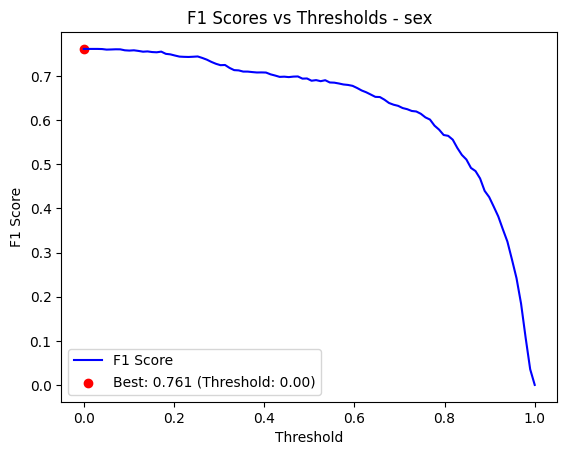

In [221]:
plot_f1(thresholds, sex_scores, best_sex_threshold, best_sex_score, 'sex' )

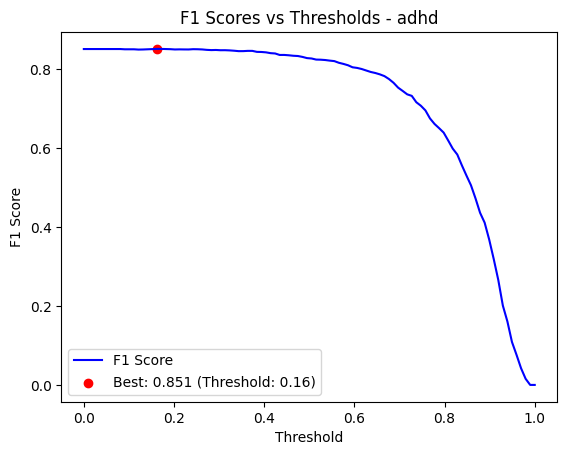

In [222]:
plot_f1(thresholds, adhd_scores, best_adhd_threshold, best_adhd_score, 'adhd' )

### PCA & CV 

In [127]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, svd_solver='full')  # Adjust based on variance explained
# reduced_data = pca.fit_transform(train_df.drop(columns = ['participant_id']))

reduced_data = pca.fit_transform(train_tf)

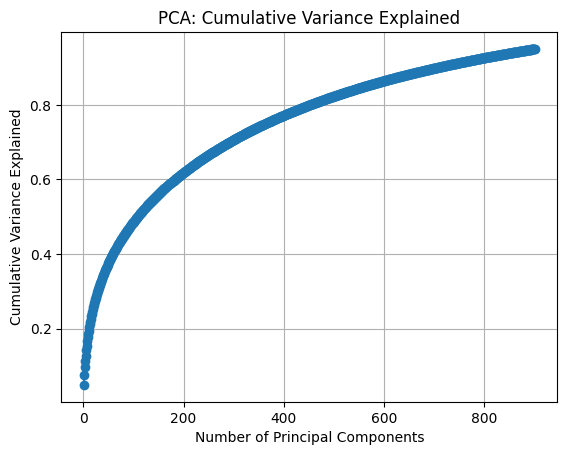

In [128]:
cumulative_variance = pca.explained_variance_ratio_.cumsum()

plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker="o", linestyle="--")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("PCA: Cumulative Variance Explained")
plt.grid()
plt.show()

### GCN + XGBoost

In [ ]:
# apply harmonization on the test_dataset
pred_ids = list(pred_mri.participant_id)
# mri_pred_split, covars_pred = prep_harmonizedata(test_mri, test_categorical, pred_ids)


In [55]:
%%time

loader = LoadMRI(pred_mri)

# Apply SPD correction to the matrices
mri_corrected_pred, mri_pred_input, patient_ids_pred = loader.load_and_correct_data(as_vectors=False)
torch.save(mri_pred_input, 'mri_data/mri_pred_input.pt')
np.save('mri_data/mri_corrected_pred.npy', mri_corrected_pred)

CPU times: user 3min 36s, sys: 49.4 s, total: 4min 25s
Wall time: 3min 15s


In [149]:
mri_corrected_pred = np.load('mri_data/mri_corrected_pred.npy')
mri_pred_input = torch.load('mri_data/mri_pred_input.pt')

In [56]:
features_pred = pred_tf[list(set(pred_tf.columns) - set(pred_mri.columns))]
pred_dataset = TestDataset(graph_data=mri_pred_input, other_features=features_pred)
pred_loader = DataLoader(pred_dataset, batch_size=32, shuffle=False)

In [57]:
embeddings_pred_list = []
with torch.no_grad():
    for data in pred_loader:
        graph_batch, other_feature = data
        graph_batch = graph_batch.to(device)

        adhd_emb_pred, sex_emb_pred, adhd_output, sex_output = gcn_model(graph_batch)
        combined_emb_pred = torch.cat([adhd_emb_pred, sex_emb_pred], dim=1)
        embeddings_pred_list.append(combined_emb_pred .cpu().numpy())

embeddings_pred = np.vstack(embeddings_pred_list)

# Combine test set features
combined_features_pred = np.concatenate((embeddings_pred, features_pred), axis=1)

# Predict
y_pred = np.array([clf.predict_proba(combined_features_pred)[:, 1] for clf in multi_output_model.estimators_]).T 


In [ ]:
# adhd_proba_test = y_pred[:, 0]
# sex_proba_test = y_pred[:, 1]


# adhd_pred = np.where(adhd_proba_test > best_adhd_threshold, 1, 0)
# sex_pred = np.where(sex_proba_test > best_sex_threshold, 1, 0)

In [78]:
adhd_pred = adhd_best_model.predict(combined_features_pred)
sex_pred = sex_best_model.predict(combined_features_pred)

In [79]:
participant_id = test_df.index
result_df = pd.DataFrame(
    {'participant_id': participant_id, 'ADHD_Outcome': adhd_pred, 'Sex_F': 1}
)

result_df.to_csv('submission.csv',index=False)

In [80]:
from collections import Counter
Counter(adhd_pred)

Counter({1: 259, 0: 45})

In [81]:
Counter(sex_pred)

Counter({0: 227, 1: 77})

## Submission

In [ ]:
best_model = ridge_nc
test = test_tf
y_pred = best_model.predict(test)
# y_pred = predictions

participant_id = test_tf.index
result_df = pd.DataFrame(
    {'participant_id': participant_id, 'ADHD_Outcome': y_pred[:, 0], 'Sex_F': y_pred[:, 1]}
)



result_df.to_csv('submission.csv',index=False)